In [121]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
wandb.login()

True

In [120]:
ENTITY = "martingratzer-organization"
PROJECT = "CIFAR-100-RD-Sigmoid-T4"
api = wandb.Api(timeout=150)
runs = api.runs(f"{ENTITY}/{PROJECT}")

In [122]:
histories = []
alphas = []

for run in runs:
    history = run.history(keys=["eval_top1", "_step"], pandas=True)
    alpha = run.config.get("alpha")

    # Add alpha as a column
    history["alpha"] = alpha

    histories.append(history)

# Combine all runs into a single DataFrame
final_df = pd.concat(histories, ignore_index=True)

In [123]:
final_df

,_step,eval_top1,alpha
0,0,1.90,0.5
1,1,2.62,0.5
2,2,3.52,0.5
3,3,3.91,0.5
4,4,4.09,0.5
...,...,...,...
15395,215,64.18,5.0
15396,216,63.95,5.0
15397,217,63.95,5.0
15398,218,63.98,5.0


In [124]:
ENTITY = "martingratzer-organization"
PROJECTS = ["CIFAR-100-RD-Sigmoid-T4", "CIFAR-100-RD", "CIFAR-100-RD-NoAlpha"]

api = wandb.Api(timeout=150)

all_histories = []

for project in PROJECTS:
    runs = api.runs(f"{ENTITY}/{project}")  # Get all runs for the project
    
    for run in runs:
        history = run.history(keys=["eval_top1", "_step"], pandas=True)
        alpha = run.config.get("alpha", None)  # Use None if alpha is missing
        history["alpha"] = alpha  # Add alpha column
        history["project"] = project  # Add project column
        
        all_histories.append(history)

# Combine all runs into a single DataFrame
final_df = pd.concat(all_histories, ignore_index=True)

# Display the first few rows
print(final_df.head())

   _step  eval_top1  alpha                  project
0      0       1.90    0.5  CIFAR-100-RD-Sigmoid-T4
1      1       2.62    0.5  CIFAR-100-RD-Sigmoid-T4
2      2       3.52    0.5  CIFAR-100-RD-Sigmoid-T4
3      3       3.91    0.5  CIFAR-100-RD-Sigmoid-T4
4      4       4.09    0.5  CIFAR-100-RD-Sigmoid-T4


In [125]:
final_df

,_step,eval_top1,alpha,project
0,0,1.90,0.5,CIFAR-100-RD-Sigmoid-T4
1,1,2.62,0.5,CIFAR-100-RD-Sigmoid-T4
2,2,3.52,0.5,CIFAR-100-RD-Sigmoid-T4
3,3,3.91,0.5,CIFAR-100-RD-Sigmoid-T4
4,4,4.09,0.5,CIFAR-100-RD-Sigmoid-T4
...,...,...,...,...
64886,215,64.08,5.0,CIFAR-100-RD-NoAlpha
64887,216,64.08,5.0,CIFAR-100-RD-NoAlpha
64888,217,63.80,5.0,CIFAR-100-RD-NoAlpha
64889,218,63.96,5.0,CIFAR-100-RD-NoAlpha


In [119]:
histories

[     _step  eval_top1
 0        0       1.90
 1        1       2.62
 2        2       3.52
 3        3       3.91
 4        4       4.09
 ..     ...        ...
 215    215      63.82
 216    216      64.40
 217    217      64.37
 218    218      64.16
 219    219      64.59
 
 [220 rows x 2 columns],
      _step  eval_top1
 0        0       2.11
 1        1       2.90
 2        2       3.40
 3        3       3.78
 4        4       4.28
 ..     ...        ...
 215    215      64.23
 216    216      64.28
 217    217      63.94
 218    218      63.74
 219    219      64.29
 
 [220 rows x 2 columns],
      _step  eval_top1
 0        0       2.21
 1        1       3.08
 2        2       3.53
 3        3       3.81
 4        4       4.22
 ..     ...        ...
 215    215      63.52
 216    216      63.89
 217    217      63.67
 218    218      63.43
 219    219      64.07
 
 [220 rows x 2 columns],
      _step  eval_top1
 0        0       1.86
 1        1       3.09
 2        2       3.12

In [139]:
filtered_df = final_df[final_df["alpha"].isin([0.5, 0.75, 1, 1.25, 1.5, 2, 5])]

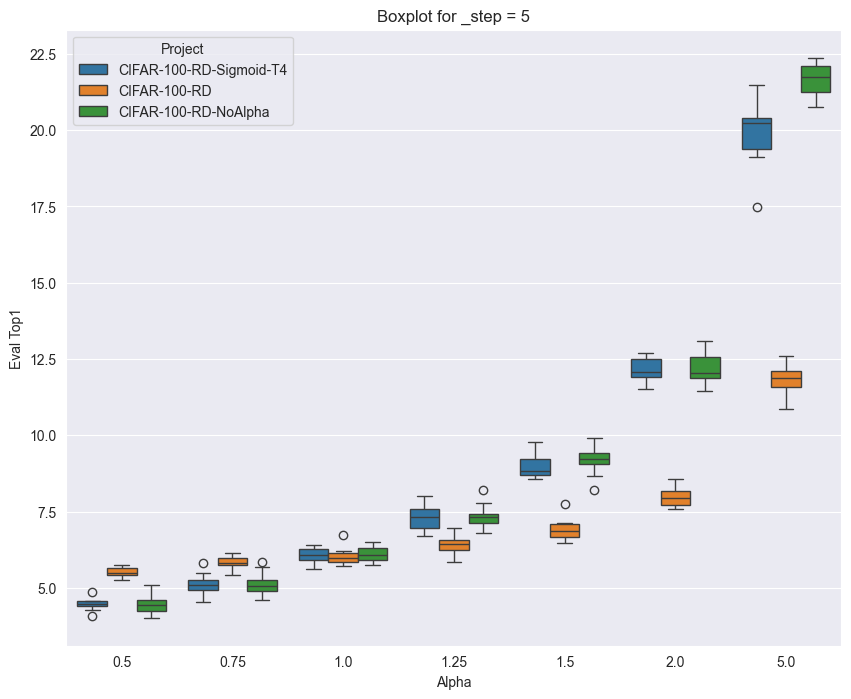

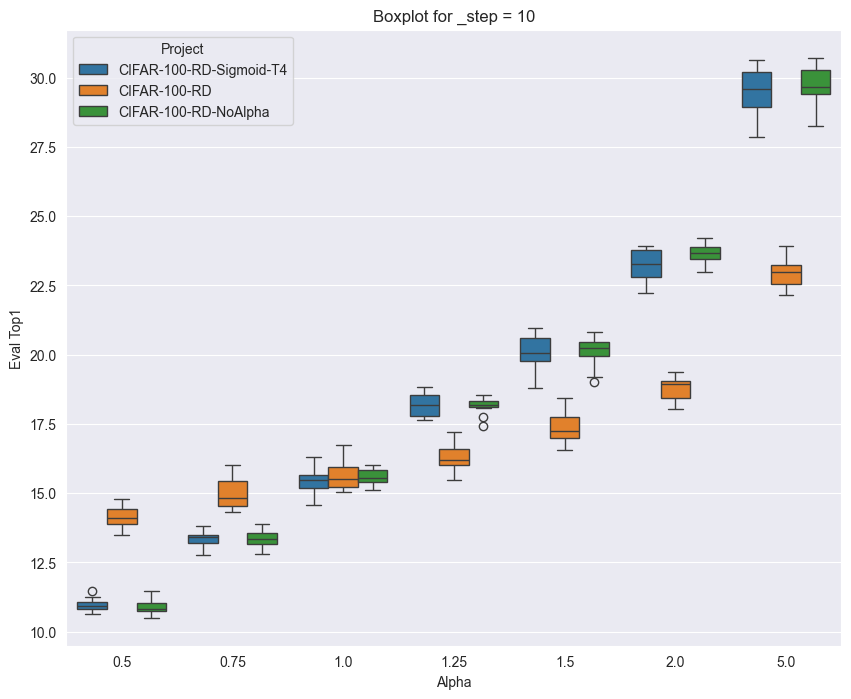

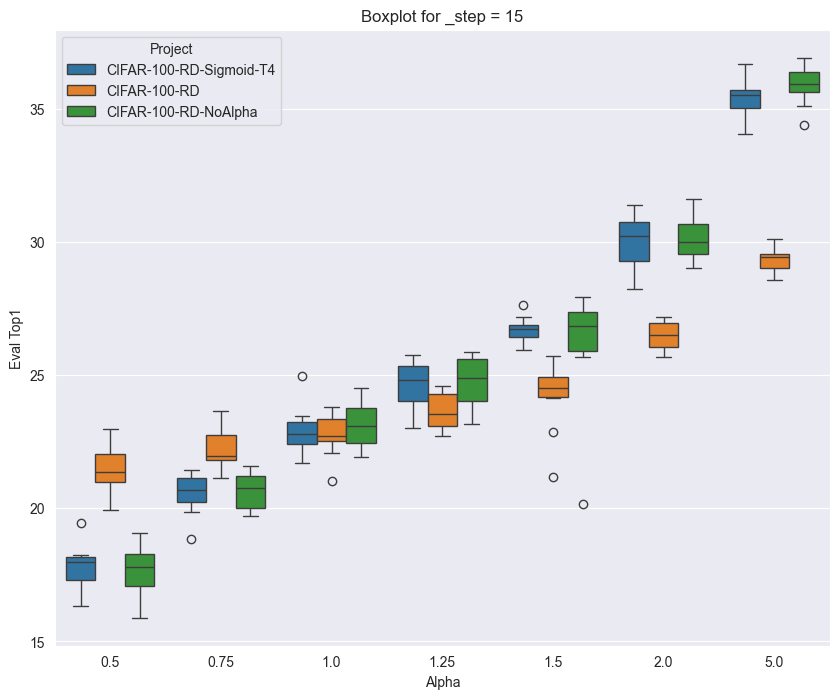

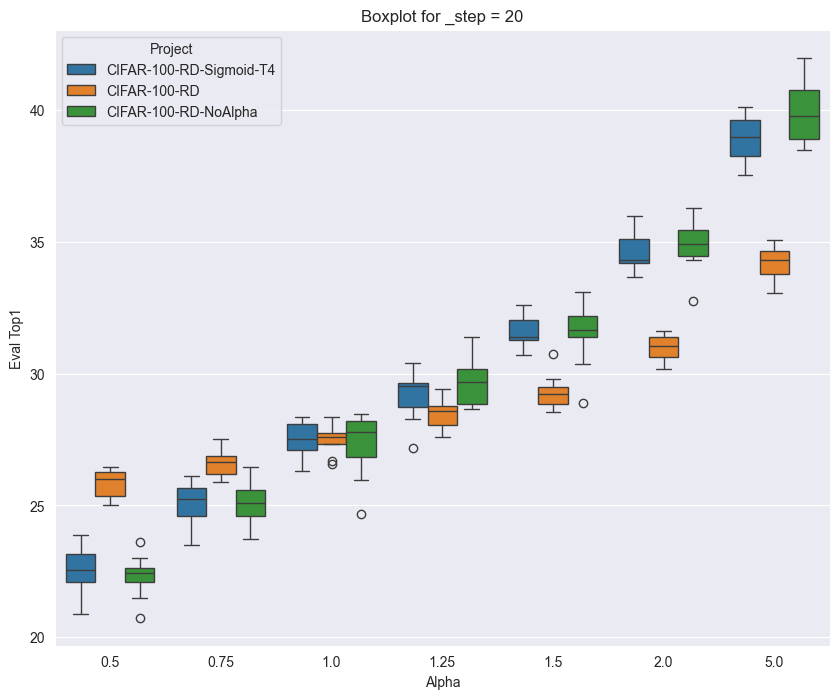

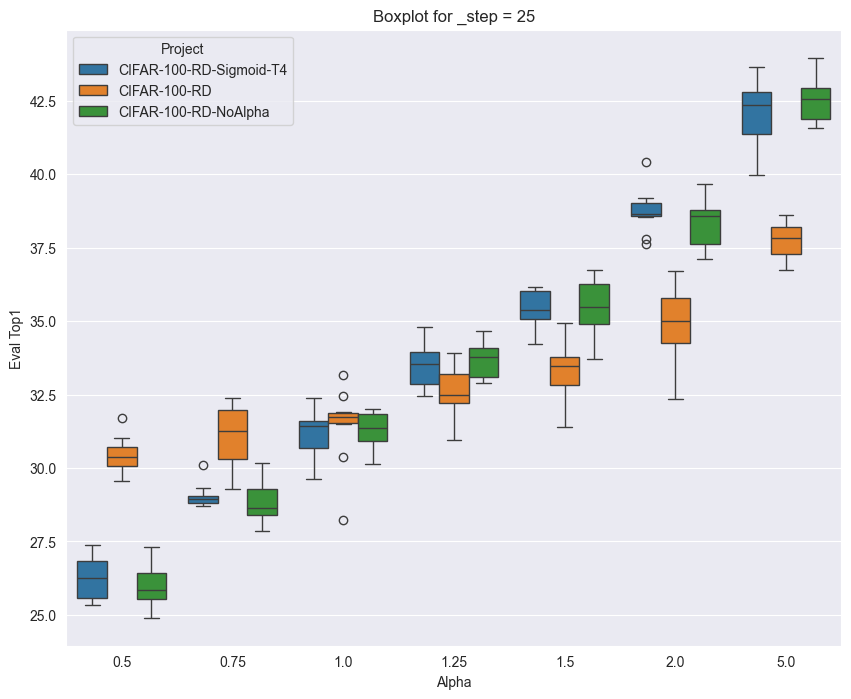

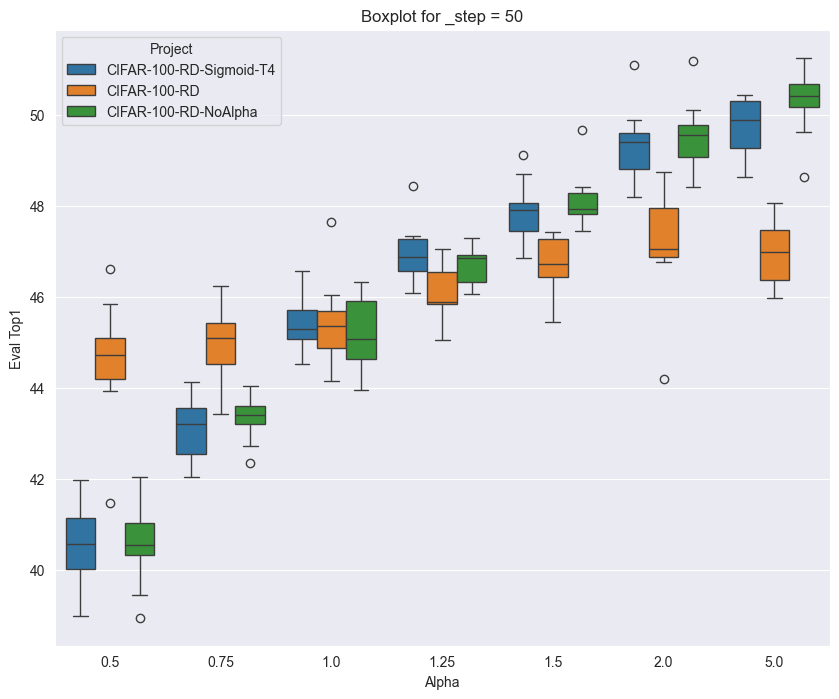

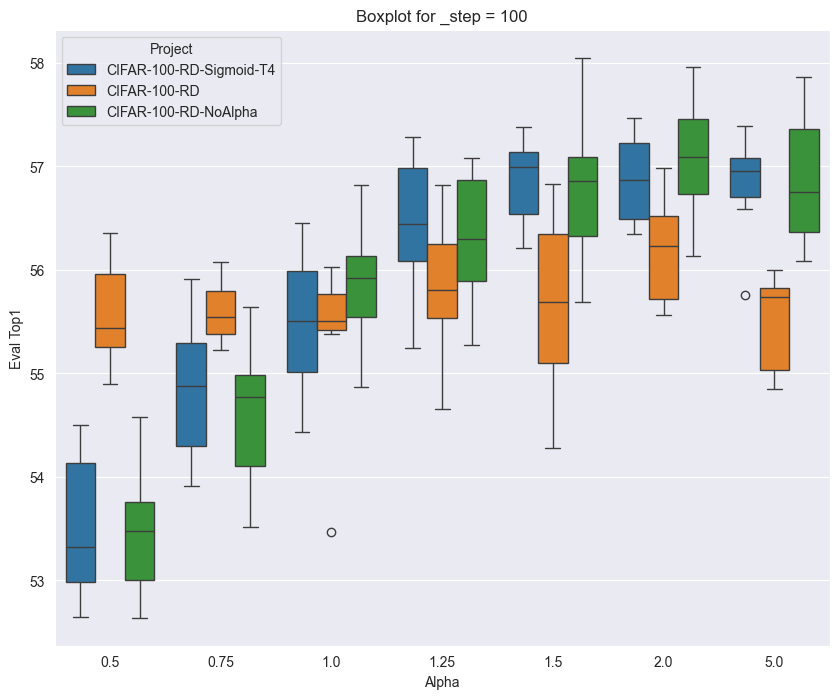

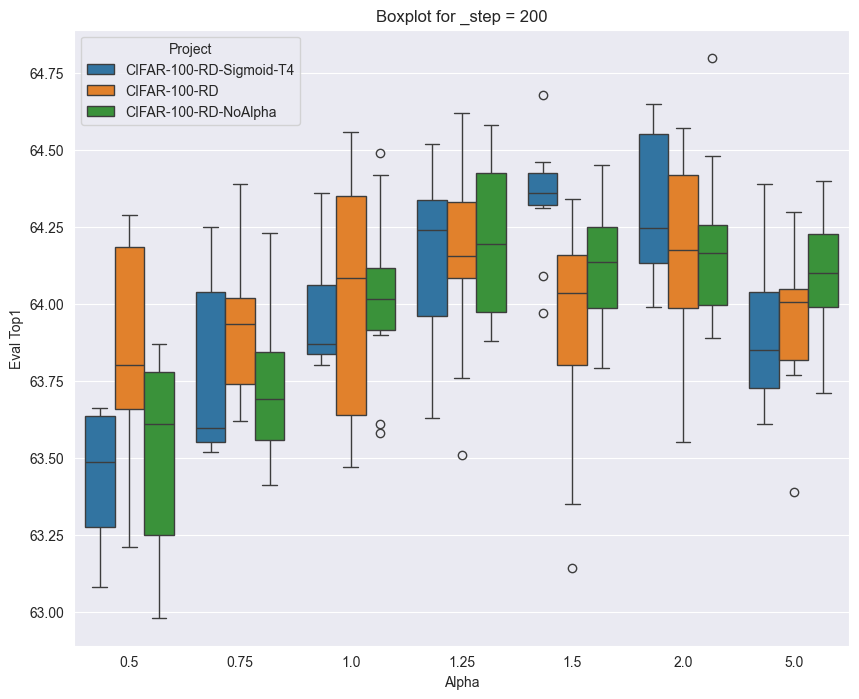

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the step values you want to plot
step_values = [5, 10, 15, 20, 25, 50, 100, 200]

for step in step_values:
    df_filtered = filtered_df[filtered_df["_step"] == step]  # Filter data for the current step

    # Create a new figure for each plot
    plt.figure(figsize=(10, 8))

    # Create the boxplot
    sns.boxplot(data=df_filtered, x="alpha", y="eval_top1", hue="project")

    # Formatting
    plt.title(f"Boxplot for _step = {step}")
    plt.xlabel("Alpha")
    plt.ylabel("Eval Top1")
    plt.legend(title="Project", loc="best")

    # Show each plot separately
    plt.show()

    # Optional: Save the plot as an image (uncomment to enable)
    # plt.savefig(f"boxplot_step_{step}.png", dpi=300, bbox_inches="tight")

    plt.close()  # Close the figure to free memory

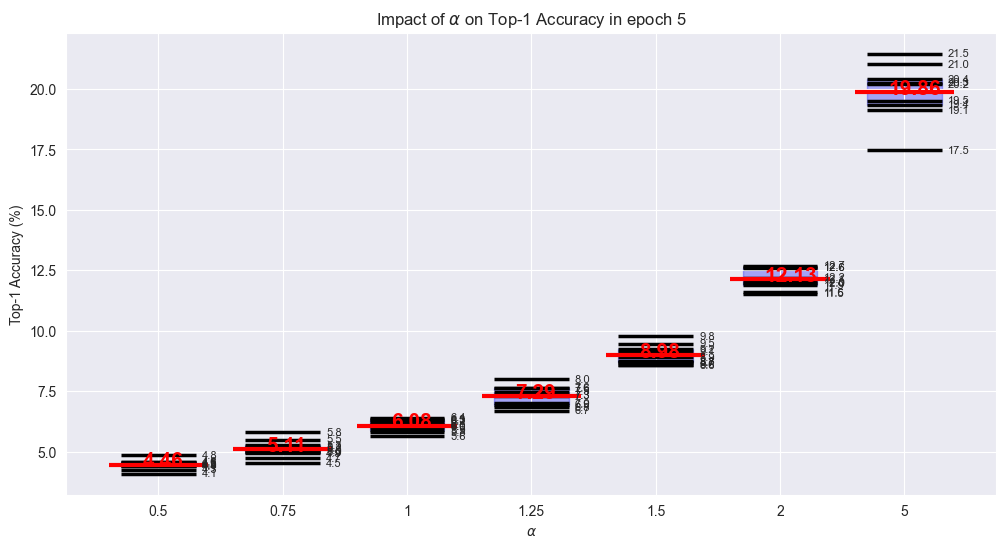

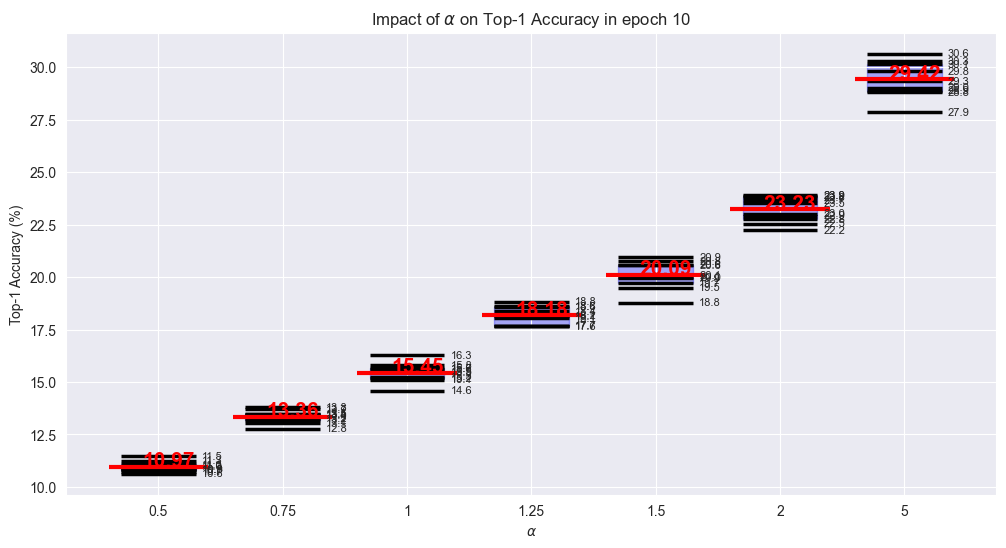

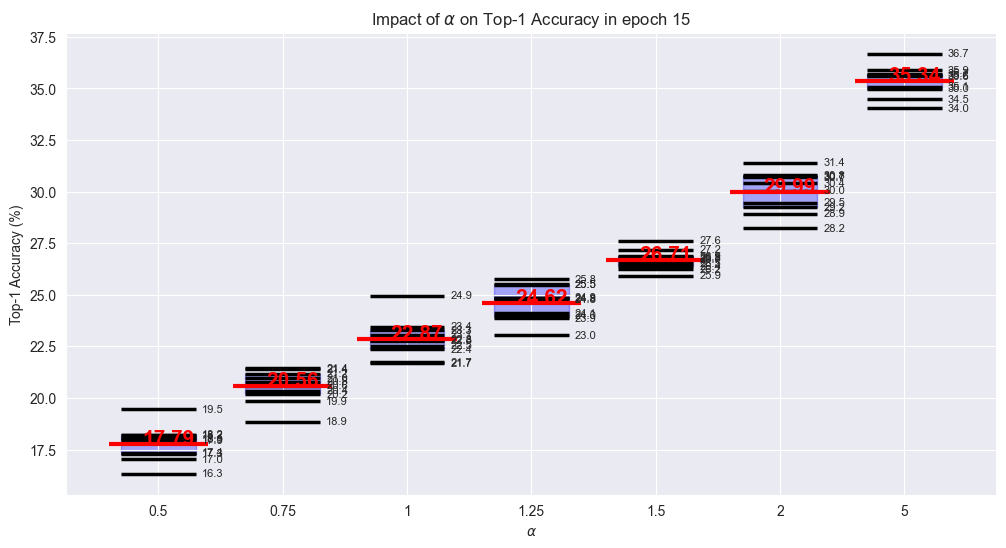

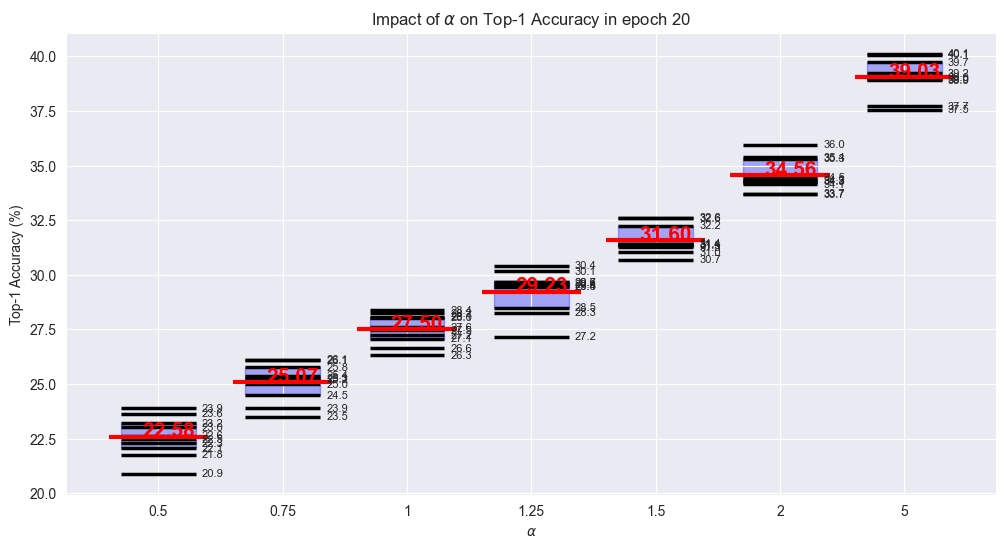

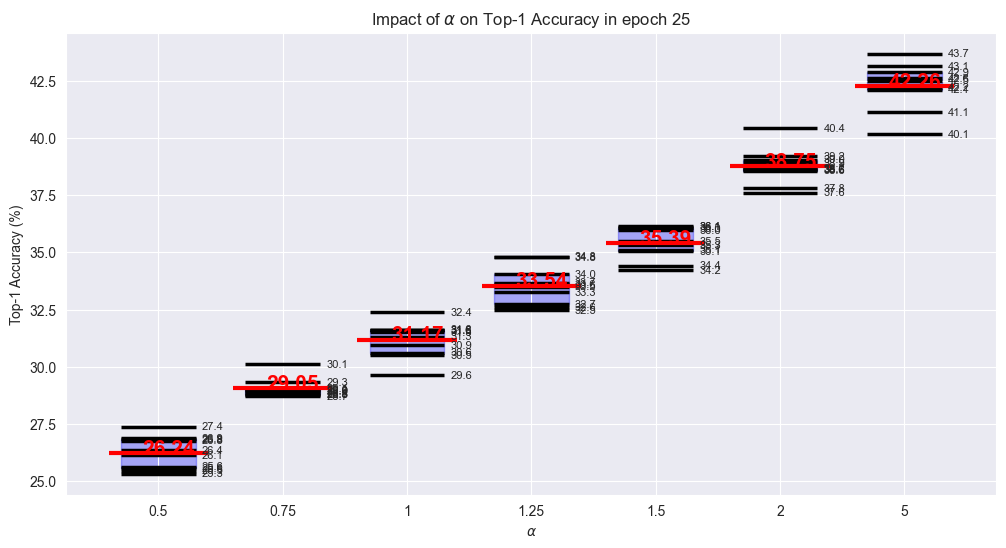

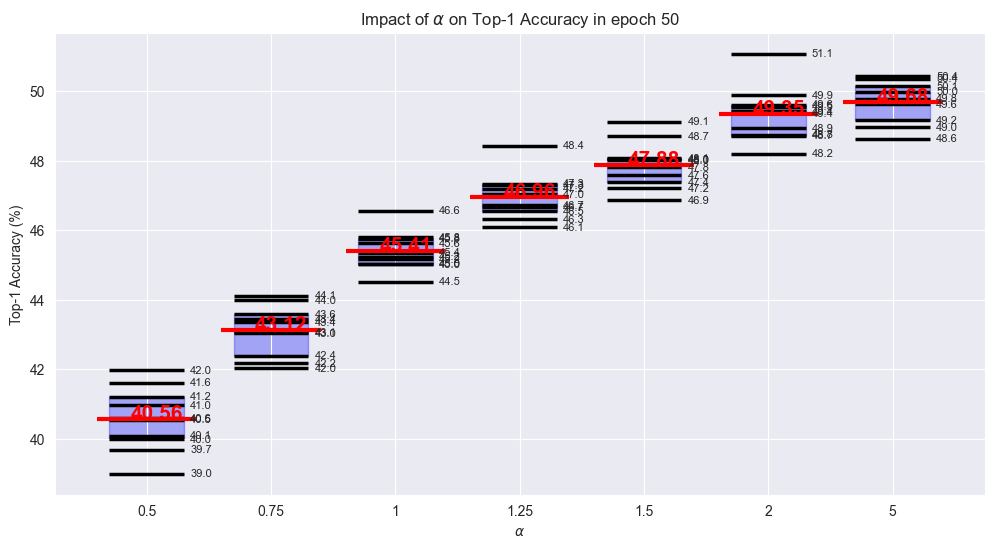

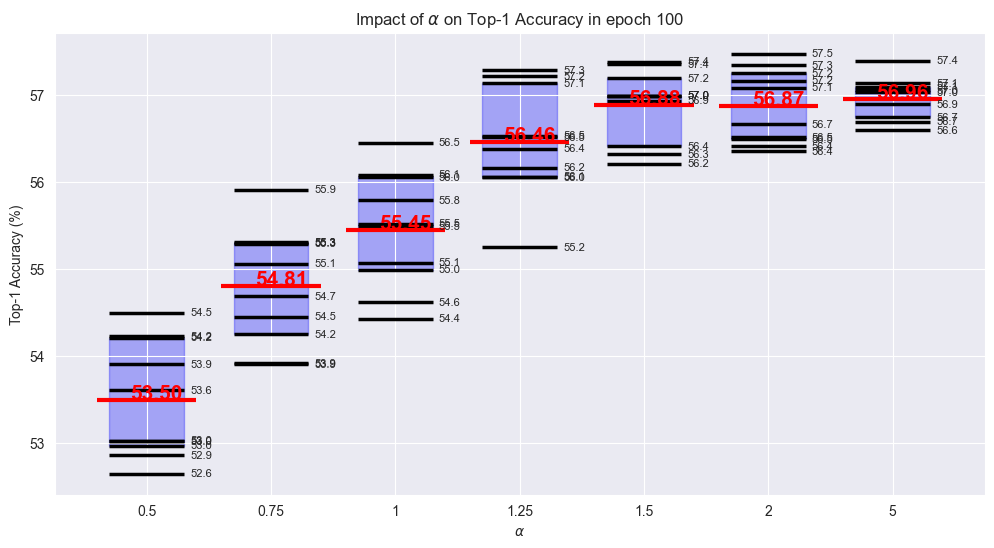

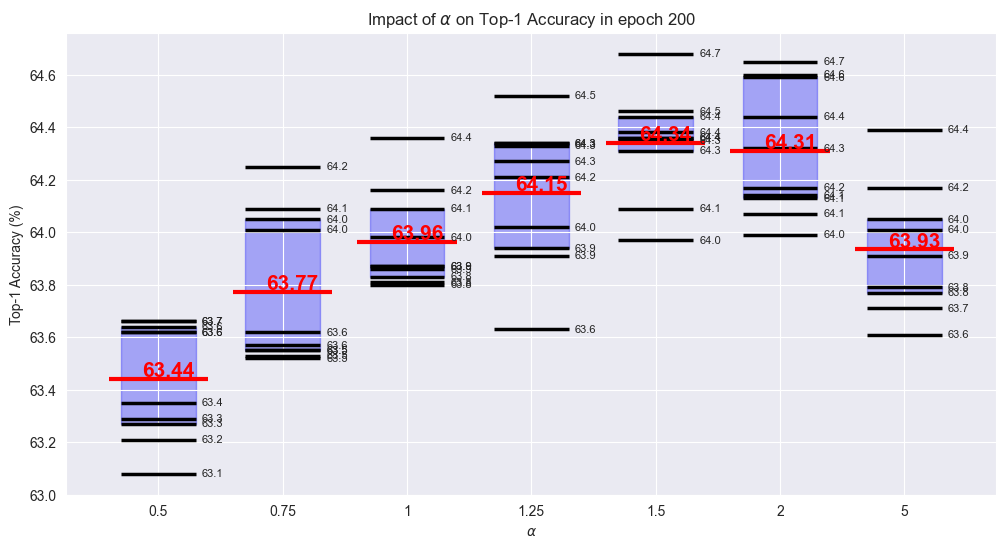

In [96]:
steps = [5,10,15,20,25,50,100,200]
mean_value_text_move = [0.15,0.28,0.25,0.25,0.2,0.15,0.07,0.03]
categories = ['0.5','0.75','1','1.25','1.5','2','5']
rectangle_possibilities = [[0,0],[0,1],[0,2],[1,2],[1,3],[1,4],[2,4],[2,5],[2,6]]
for iter,step in enumerate(steps):
    
    data = {}
    for j,alpha in enumerate(categories):
        x = []
        
        if alpha == categories[-1]:
            runs_of_last_category = len(histories)-10*(len(categories)-1)-1
            for i in range(runs_of_last_category):
                x.append(np.round(histories[10*j+i][step]['eval_top1'],2))
        else:
            for i in range(10):
                x.append(np.round(histories[10*j+i][step]['eval_top1'],2))
        data[alpha] = x
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define the width of each dash line
    line_width = 0.3  # Controls the horizontal length of dashes
    boldness = 2.5  # Controls line thickness
    
    # Loop over each category and plot its observations
    for i, alpha in enumerate(categories):
        y = sorted(data[alpha])  # Sort values to determine the range for the rectangle
        x_start = np.full_like(y, i - line_width)  # Left endpoint
        x_end = np.full_like(y, i + line_width)  # Right endpoint
        
        # Get the range for the blue rectangle (between the 3rd and 8th best observations)
        if alpha == categories[-1]:
            lower_bound = y[rectangle_possibilities[runs_of_last_category-1][0]]
            upper_bound = y[rectangle_possibilities[runs_of_last_category-1][1]]
        else:
            lower_bound = y[2]  # 3rd best observation
            upper_bound = y[7]  # 8th best observation
        rect_width = 0.6  # Controls how wide the rectangle is
    
        # Draw the blue rectangle below observations
        ax.add_patch(plt.Rectangle((i - rect_width / 2, lower_bound), rect_width, upper_bound - lower_bound,
                                   color='blue', alpha=0.3, zorder=0))
    
        # Plot horizontal black lines for observations
        for xs, xe, yi in zip(x_start, x_end, y):
            ax.hlines(y=yi, xmin=xs, xmax=xe, color='black', linewidth=boldness)
            ax.text(xe + 0.05, yi, f'{yi:.1f}', va='center', fontsize=8)
    
        # Calculate and plot the mean line in red
        mean_value = np.mean(y)
        ax.hlines(y=mean_value, xmin=i - 0.4, xmax=i + 0.4, color='red', linewidth=3, label='Mean' if i == 0 else "")
        
        # Annotate the mean value in red
        ax.text(i-0.13, mean_value+mean_value_text_move[iter], f'{mean_value:.2f}', color='red', va='center', fontsize=15, fontweight='bold')
    
    # Set category labels on the x-axis.
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    
    # Add labels and title.
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Top-1 Accuracy (%)')
    ax.set_title(r'Impact of $\alpha$ on Top-1 Accuracy' + f' in epoch {step}')
    
    plt.show()

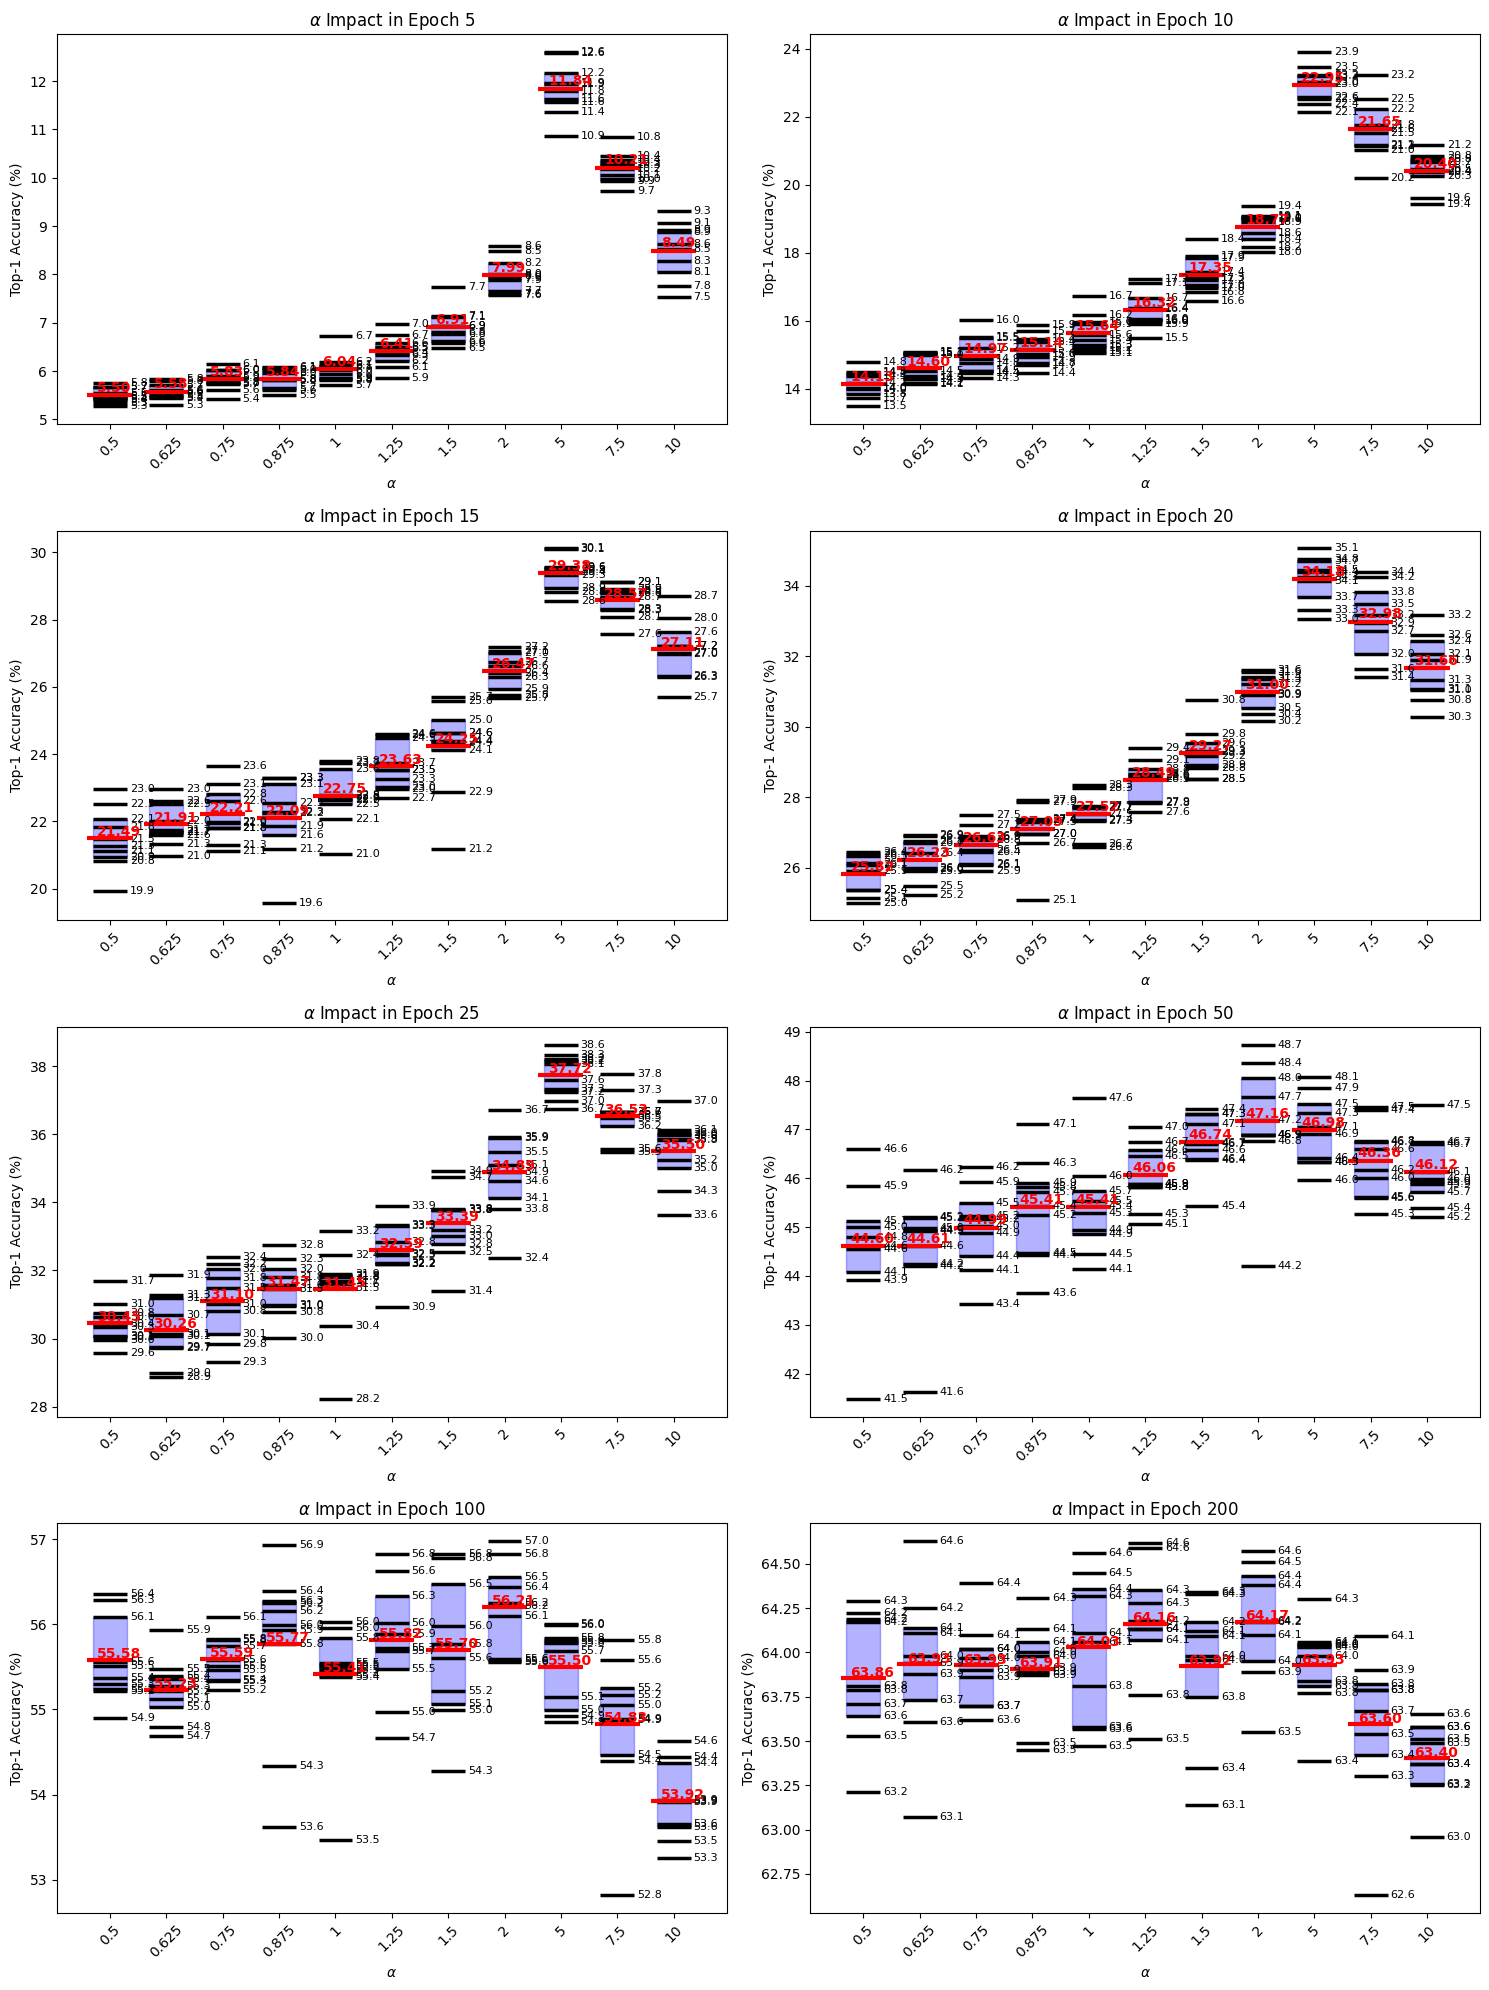

In [83]:
import numpy as np
import matplotlib.pyplot as plt

steps = [5, 10, 15, 20, 25, 50, 100, 200]
mean_value_text_move = [0.15, 0.2, 0.2, 0.2, 0.18, 0.15, 0.07, 0.03]
categories = ['0.5', '0.625', '0.75', '0.875', '1', '1.25', '1.5', '2', '5', '7.5', '10']

fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # Create 2x4 grid

for iter, step in enumerate(steps):
    row, col = divmod(iter, 2)  # Determine grid position
    ax = axes[row, col]  # Select subplot

    data = {}
    for j, alpha in enumerate(categories):
        x = [np.round(histories[10 * j + i][step]['eval_top1'], 2) for i in range(10)]
        data[alpha] = x

    # Define the width of each dash line
    line_width = 0.3  
    boldness = 2.5  

    # Loop over each category and plot observations
    for i, cat in enumerate(categories):
        y = sorted(data[cat])  
        x_start = np.full_like(y, i - line_width)  
        x_end = np.full_like(y, i + line_width)  

        # Blue rectangle for range (between 3rd and 8th best observations)
        lower_bound, upper_bound = y[2], y[7]  
        rect_width = 0.6  

        ax.add_patch(plt.Rectangle((i - rect_width / 2, lower_bound), rect_width, upper_bound - lower_bound,
                                   color='blue', alpha=0.3, zorder=0))

        # Plot horizontal black lines for observations
        for xs, xe, yi in zip(x_start, x_end, y):
            ax.hlines(y=yi, xmin=xs, xmax=xe, color='black', linewidth=boldness)
            ax.text(xe + 0.05, yi, f'{yi:.1f}', va='center', fontsize=8)

        # Calculate and plot mean line in red
        mean_value = np.mean(y)
        ax.hlines(y=mean_value, xmin=i - 0.4, xmax=i + 0.4, color='red', linewidth=3)
        ax.text(i - 0.23, mean_value + mean_value_text_move[iter], f'{mean_value:.2f}', 
                color='red', va='center', fontsize=10, fontweight='bold')

    # Set category labels
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45)

    # Labels and title
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Top-1 Accuracy (%)')
    ax.set_title(rf'$\alpha$ Impact in Epoch {step}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()
